 
In this notebook we will investigate how good small neural networks are at predicting an important number-theoretic function, and investigate other number-theoretic properties like divisibility and factorisation. We will be taking for granted a lot of the background covered in tensorflow

#  Predicting the Möbius function

The [Möbius function](https://en.wikipedia.org/wiki/Möbius_function) $\mu(n)$ indicates whether the positive integer $n$ has a squarefree factorisation into primes, and if so whether there are an odd or even number of distinct prime factors:

$$
\mu(n) = \begin{cases}
-1 & \text{ if $n$ is squarefree with an odd number of prime factors, } \\
0 & \text{ if $n$ has a repeated prime factor, and} \\
+1 & \text{ if $n$ is squarefree with an even number of prime factors.}
\end{cases}
$$

Our goal is to train a neural net to predict the values of $\mu$.

Fix a bit-length $B \geq 1$, then we will look at predicting $\mu(n)$ for $n$ in the range $[0, 2^B)$, i.e. numbers of length at most $B$ when written in binary. The neural network will act as a map $\mathbb{R}^B \to \mathbb{R}^3$, where the input for $n$ is a $B$-long vector of 1's and 0's (the binary representation of $n$), and the output vector in $\mathbb{R}^3$ has the first slot corresponding to $-1$, the second to $0$, and the third to $+1$.

For instance, if $B = 5$ then we are working with the numbers $n \in \{0, 1, \ldots, 31\}$. The number $n = 13$ would correspond to the input vector $[0, 1, 1, 0, 1]$, and the neural network might output $[-0.14, 0.02, 0.53]$: we would interpret these outputs using the [Softmax](https://pytorch.org/docs/stable/generated/torch.sparse.softmax.html) function to be the probability distribution $[24\%, 29\%, 47\%]$, and take the maximum-likelihood result as being its classification, corresponding to the statement "$\mu(13)$ is predicted to be $1$". In this case it would have gotten the wrong answer: $13$ is prime and so $\mu(13) = -1$.

In [ ]:
import functools
import random

from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.optim
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


## Auxiliary functions

Firstly we will need to calculate $\mu(n)$ for $n$ in a large range, which can be done using a prime sieve (and other sieving techniques). We will also need a function which outputs a big array of all the binary representations of numbers in the range $[0, 2^B)$.

To find all primes in the range $[0, N)$ we will use the [Sieve of Eratosthenes](https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes). Once we have a list of primes below $N$, we can similarly use sieving techniques to calculate $\mu(n)$ quickly for all $n \in [0, N)$.

**Tangential exercise**: using the approximation $1 + 1/2 + 1/3 + \cdots + 1/n = O(\log n)$ of the harmonic series, show that sieving primes up to $N$ takes $O(N \log N)$ time. Using trial division on each number would take $1 + \sqrt{2} + \sqrt{3} + \cdots + \sqrt{N} = O(N^{3/2})$ time. If $N = 10^7$ then sieving primes using the function below takes about a second: approximately how long would it take using trial division?

> The tangential exercise is unimportant from a machine learning perspective, but important if you are not used to algorithms: a better algorithm can be the difference between a program finishing in a second or finishing next week. This is especially important if you are trying to generate tons of data to feed into a neural network!

In [ ]:
@functools.lru_cache(maxsize=None)
def primes_upto(N: int) -> List[int]:
    """
    Return the prime numbers in the range [0, N) in increasing order.

    >>> primes_upto(2)
    []
    >>> primes_upto(3)
    [2]
    >>> primes_upto(100)
    [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]
    """

    # N should be at least 2 to run the sieve below.
    if N <= 1:
        return []

    # Sieve of Eratosthenes, using an array of integers of 0 (not prime) or 1 (prime).
    sieve = [1] * N
    sieve[0] = 0
    sieve[1] = 0
    for i in range(2, N):
        if sieve[i] == 1:
            for j in range(i*i, N, i):
                sieve[j] = 0

    return [p for p in range(N) if sieve[p] == 1]


def omega_upto(N: int) -> Tuple[List[int], List[int]]:
    """
    The little-omega of n is the number of distinct prime factors of n, and the big-omega of n is the
    number of prime factors of n counting multiplicity: https://en.wikipedia.org/wiki/Prime_omega_function.

    The function omega_upto returns two parallel arrays of N elements, giving the little and big omegas of [0, N).

    >>> little_omega, big_omega = omega_upto(40)
    >>> little_omega
    [0, 0, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 3, 1, 1, 2, 2, 2, 2, 1, 2, 2]
    >>> big_omega
    [0, 0, 1, 1, 2, 1, 2, 1, 3, 2, 2, 1, 3, 1, 2, 2, 4, 1, 3, 1, 3, 2, 2, 1, 4, 2, 2, 3, 3, 1, 3, 1, 5, 2, 2, 2, 4, 1, 2, 2]
    """

    little = [0] * N
    big = [0] * N

    for p in primes_upto(N):
        # For each prime, mark off its multiples in the little array.
        for i in range(p, N, p):
            little[i] += 1

        # For each prime power, mark off its multiples in the big array.
        power = p
        while power < N:
            for i in range(power, N, power):
                big[i] += 1
            power *= p

    return little, big


def mobius_upto(N: int) -> List[int]:
    """
    The mobius function of n is::

        +1 if n has an even number of prime factors, all distinct,
        -1 if n has an odd number of prime factors, all distinct, and
         0 if n has a repeated prime factor.

    We define the mobius function at 0 to be equal to 1.

    >>> mobius_upto(40)
    [1, 1, -1, -1, 0, -1, 1, -1, 0, 0, 1, -1, 0, -1, 1, 1, 0, -1, 0, -1, 0, 1, 1, -1, 0, 0, 1, 0, 0, -1, -1, -1, 0, 1, 1, 1, 0, -1, 1, 1]
    """

    little_omega, big_omega = omega_upto(N)
    return [
        0 if little_omega[i] != big_omega[i] else 1 if little_omega[i] % 2 == 0 else -1
        for i in range(N)
    ]

The function `binary_block(B)` takes an integer $B$ and returns a tensor $T$ of shape $(2^B, B)$ such that $T[i, :]$ is the $B$-bit binary representation of $i$.

In [ ]:
def binary_block(bits: int):
    """
    Return a tensor T of shape (2^bits, bits) such that T[i, :] is a 01-vector
    of length bits, containing the binary representation of i. For example:

    >>> binary_block(2)
    array([[0, 0],
           [0, 1],
           [1, 0],
           [1, 1]])
    >>> binary_block(3)[6,:]
    array([1, 1, 0])
    """
    # Matrix of coordinates 100, 010, 001 etc.
    coords = np.identity(bits, dtype=int)

    # Add 0 or 1 lots of coords in every way possible.
    result = np.zeros(bits, dtype=int)
    for i in reversed(range(bits)):
        result = np.row_stack([result, result + coords[:,i]])

    return result

## A dataset

Fix a bit-length $B$, then our dataset will consist of $2^B$ inputs, stored in a tensor $T$ of shape $(2^B, B)$, such that $T[i, :]$ is a $B$-long vector 01 vector, and $2^B$ output categories, a $2^B$-long vector taking values in $\{0, 1, 2\}$. (PyTorch really wants a problem featuring $C$ categories to be labelled $[0, C)$, so we will shift the range $\{-1, 0, 1\}$ up to $\{0, 1, 2\}$ by adding $1$).

The function `create_dataset(bits)` will take the bit-length `B` and return three objects:
- A Python array `mu` containing the values of the mobius function, eg `mu[n] = \mu(n)`.
- A `float32` tensor `mu_input` of shape $(2^B, B)$: the inputs to the network.
- A `long` tensor `mu_output` of shape $(2^B)$ taking values in $[0, 1, 2]$: `mu_output[n] = \mu(n) + 1`.

> *Note:* The exponentiation operator is written as `**` in Python, so $a^b$ is written `a ** b`.

In [ ]:
def create_dataset(bits: int) -> Tuple[int, int, np.array, np.array]:
    mu = mobius_upto(2**bits)
    mu_input = torch.tensor(binary_block(bits), dtype=torch.float32)
    mu_output = torch.tensor(mu) + 1

    return mu, mu_input, mu_output
  
create_dataset(3)

([1, 1, -1, -1, 0, -1, 1, -1], tensor([[0., 0., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [0., 1., 1.],
         [1., 0., 0.],
         [1., 0., 1.],
         [1., 1., 0.],
         [1., 1., 1.]]), tensor([2, 2, 0, 0, 1, 0, 2, 0]))

## Network structure

We will have a flexible network structure, requiring that there is an input layer of size $B$, an output layer of size $3$, and zero or more *hidden layers*. Every layer is an affine function, with all but the last layer followed by the [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) activation function.

The `create_network` function is a helper for making these kind of simple networks.

In [ ]:
def create_network(layers: List[int]):
    return nn.Sequential(*[
        module
        for x, y in zip(layers, layers[1:])
        for module in [nn.Linear(x, y), nn.ReLU()]
    ][:-1])


# An example network (not the one we will end up using!)
create_network([8, 50, 20, 3])

Sequential(
  (0): Linear(in_features=8, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=3, bias=True)
)

## Training

 We will be using the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html), and [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) as the training method.

We will allow the training process to see 50% of the data in the whole dataset.

> *Technical point 1*: Since we now have a large dataset, tracking the loss over time against the training and validation datasets becomes quite expensive and slows down the program. Hence we only calculate them every 100 epochs.

> *Technical point 2*: We also use the special `with torch.no_grad():` block when running data through the network when we have no intention of performing gradient descent on the results. This block stops PyTorch from tracking auxiliary data in the `recorded_loss` tensor - we don't need this because we're never going to ask for the derivative in the `recorded_loss` tensor.

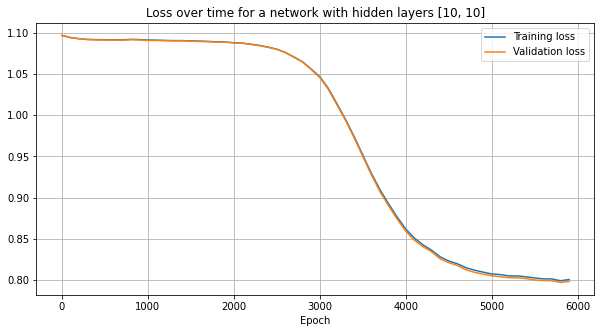

In [ ]:
# Set the bitsize and create the dataset.
BITS = 16
mu, mu_input, mu_output = create_dataset(BITS)

# Select 50% of the data to be training data.
indices = torch.randperm(2**BITS)
training_idx, validation_idx = indices[:2**BITS // 2], indices[2**BITS // 2:]
mu_input_training, mu_output_training = mu_input[training_idx], mu_output[training_idx]
mu_input_validation, mu_output_validation = mu_input[validation_idx], mu_output[validation_idx]

def create_and_train_binary_model(hidden_layers: List[int], epochs: int):
    model = create_network([BITS] + hidden_layers + [3])
    loss_function = nn.CrossEntropyLoss()
    optimiser = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.01)

    # We will record the loss functions across the dataset every 100 epochs.
    LOSS_INTERVAL = 100
    recorded_loss = torch.full(size=(epochs//LOSS_INTERVAL, 3), fill_value=0.0)

    # At each epoch, show the network 10 data points and do gradient descent.
    for epoch in range(epochs):
        training_size = mu_input_training.shape[0]
        batch = torch.tensor(random.sample(range(training_size), k=10))

        optimiser.zero_grad()
        model_output = model(mu_input_training[batch])
        loss = loss_function(model_output, mu_output_training[batch])
        loss.backward()
        optimiser.step()

        if epoch % LOSS_INTERVAL == 0:
            # Record the training and validation loss of the network at each epoch.
            # We do this with no_grad enabled: this disables computation tracking and uses much less RAM.
            with torch.no_grad():
                recorded_loss[epoch // LOSS_INTERVAL, 0] = epoch
                recorded_loss[epoch // LOSS_INTERVAL, 1] = loss_function(model(mu_input_training), mu_output_training)
                recorded_loss[epoch // LOSS_INTERVAL, 2] = loss_function(model(mu_input_validation), mu_output_validation)

    return model, recorded_loss

hidden_layers = [10, 10]
binary_model, loss = create_and_train_binary_model(hidden_layers, epochs=6000)

# Plot the loss function over time.
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss[:, 0], loss[:, 1], label='Training loss')
ax.plot(loss[:, 0], loss[:, 2], label='Validation loss')
ax.set_xlabel('Epoch')
ax.legend()
ax.grid()
ax.set_title(f"Loss over time for a network with hidden layers {hidden_layers}")
plt.show()

In [ ]:
list(binary_model.parameters())

[Parameter containing:
 tensor([[ 0.1937,  0.2064,  0.0450, -0.0500, -0.1303,  0.1041,  0.0646, -0.1350,
           0.1543, -0.0598, -0.1210, -0.1336,  0.1567, -0.0100,  0.3884,  0.1897],
         [ 0.1432, -0.0127, -0.0789,  0.1070,  0.1034,  0.0714,  0.1400,  0.0057,
           0.0289, -0.0899,  0.1031,  0.0180,  0.0246, -0.0566, -0.5416, -0.5053],
         [-0.2489, -0.1987,  0.1811, -0.0589, -0.1346,  0.0436,  0.0522, -0.1100,
          -0.0569,  0.0551, -0.0348, -0.2436,  0.1455,  0.0792,  0.0576, -0.1106],
         [ 0.0921,  0.1529,  0.1191,  0.1913,  0.0429,  0.1680, -0.0333,  0.1686,
           0.1206,  0.2297,  0.1524, -0.0647,  0.1315,  0.1677, -0.8076, -1.0008],
         [ 0.1998, -0.0182,  0.2128,  0.2373, -0.1147,  0.0686,  0.0613,  0.1838,
          -0.0679, -0.0494,  0.1090,  0.0482, -0.0453, -0.1973, -0.2006, -0.0782],
         [ 0.0739, -0.1145, -0.1756, -0.1331, -0.2405, -0.0239, -0.0278, -0.1277,
          -0.0216, -0.1686, -0.2441, -0.2229,  0.2349,  0.0541, -0.019

## Evaluation

The network has been trained on a little less than 50% of the total data (20 epochs, sampling 2.5% of the dataset with replacement each time). Now we check to see how good the network is at predicting the mobius function on the whole dataset. We do this by building a dataframe of triples $(n, \mu(n), \text{prediction})$ and then finding the percentages of $(\mu(n), \text{prediction})$ items.

In [ ]:
with torch.no_grad():
  results = pd.DataFrame.from_dict({
      'n': range(2**BITS),
      'actual': mu,
      'predicted': (torch.max(binary_model(mu_input), dim=1).indices - 1),
  })

results

,n,actual,predicted
0,0,1,0
1,1,1,-1
2,2,-1,1
3,3,-1,-1
4,4,0,0
...,...,...,...
65531,65531,1,-1
65532,65532,0,0
65533,65533,0,0
65534,65534,1,0


The table below shows the percentages of (actual, predicted). Here is an example table from one of my runs:

| predicted | -1   | 0    | 1    |
|-----------|------|------|------|
| actual    |      |      |      |
| -1        | 0.15 | 0.00 | 0.16 |
| 0         | 0.07 | 0.25 | 0.07 |
| 1         | 0.14 | 0.00 | 0.16 |

This shows for instance that whenever the neural network predicts that $\mu(n) = 0$, then that prediction is true almost all the time (to within a percent, because of rounding).

In [ ]:
counts = results.pivot_table(index='actual', columns='predicted', aggfunc=len, fill_value=0)
(counts / counts.sum().sum()).round(2)

n            
predicted    -1     0     1
actual                     
-1         0.19  0.00  0.12
 0         0.09  0.25  0.05
 1         0.19  0.00  0.12

The next table shows how accurately the neural network predicts the absolute value $|\mu(n)|$: this function is $1$ if $n$ has distinct prime factors, or $0$ if $n$ has a repeated prime factor. In the same run as above I got

| predicted | 0    | 1    |
|-----------|------|------|
| actual    |      |      |
| 0         | 0.25 | 0.14 |
| 1         | 0.00 | 0.61 |

which shows that the network can predict the absolute value pretty well, albeit with some false positives for $|\mu(n) = 1|$.

In [ ]:
counts_abs = np.abs(results).pivot_table(index='actual', columns='predicted', aggfunc=len, fill_value=0)
(counts_abs / counts_abs.sum().sum()).round(2)

n      
predicted     0     1
actual               
0          0.25  0.14
1          0.00  0.61

# Task 2: Divisibility

Make a neural network to predict, given the binary representation of a $B$-bit number, whether the number is divisible by some other fixed number $D$ (say 2, or 12).

The following block should start you off with the required inputs and outputs: the inputs will again be a tensor containing the binary representation of all integers in the range $[0, 2^B)$, while the output will be $0$ meaning "indivisible" and $1$ meaning "divisible".

Questions to explore:

1. How few parameters can you get away with? What about when $D$ is "easy" (for example a power of 2)?
2. Which divisors $D$ seem to be "hard" for the network?
3. By reducing $n = n_0 + 2 n_1 + 2^2 n_2 + 2^3 n_3 + \cdots$ modulo $D$ you can come up with (sometimes simple) divisibility rules which only look at the binary digits. For simple cases like $D = 2$ or $D = 3$, do the parameters of the neural network reflect these?



In [ ]:
BITS = 10
D = 5
inputs = binary_block(BITS)
outputs = torch.tensor([1 if i % D == 0 else 0 for i in range(2**BITS)])

# Check the first 20 outputs to make sure we get what we're expecting.
outputs[:20]

tensor([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

# Task 3: Residue classes

Rather than classifying a number as either divisible or not divisible by $D$, instead classify a number into one of the residue classes $\{0, 1, \ldots, D-1\}$. Does the network do a better job on this problem, or on divisibility?

# Task 4: Möbius revisited

Machine learning has historically been done by thinking very hard about a good nonlinear transformation to apply to data, then following that transform with a linear (or at least relatively simple) classifier of some kind.

In number theory there is an obvious transformation to apply, which is taking a number $n = 2^{\nu_2} 3^{\nu_3} 5^{\nu_5} \cdots$ to its "prime factorisation vector" $[\nu_1, \nu_2,  \nu_3, \ldots]$. Let's see what happens in our example above if we were to feed this into the neural network instead. We've provided the function which builds the tensor of prime factorisations.

Let $\pi(N)$ be the number of primes in the range $[0, N)$ (slightly different from the standard definition), then the function `prime_exponents_upto` will return a tensor `T` of shape $(N, \pi(N))$ such that $T[n, :]$ is the list of exponents appearing in the prime factorisation of $n$. It also returns a tensor of the primes, so that we can double-check the transformation worked properly.

In [ ]:
def prime_exponents_upto(N: int):
    """
    Return a tensor of shape (N, pi(N)) where pi(N) is the number of primes in the
    range [0, N), representing each number as its prime factorisation.
    """
    primes = primes_upto(N)
    pi = len(primes)

    exponents = torch.full(size=(N, pi), fill_value=0.0)
    for i, p in enumerate(primes):
        power = p
        while power < N:
            for j in range(power, N, power):
                exponents[j, i] += 1
            power *= p
    
    return torch.tensor(primes), exponents

primes, exponents = prime_exponents_upto(20)
exponents

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 0., 0.],
        [0., 2., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0.],
        [2., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0.],
        [4., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 2., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1.]])

We can double-check that our function worked by trying to apply the inverse transformation. There is some tensor trickery going on here: we have a tensor $T$ of shape $(N, \pi(N))$ containing the exponents, where $T[n, i] = \nu_{p_i}(n)$ for $p_i$ the $i$th prime, and a tensor $P$ of shape $(\pi(N))$ where $P[i] = p_i$. The exponentiation operator `**` follows [Numpy broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) (bookmark that link for a perusal later!) and interprets `T ** P` to be the tensor $(P\mathtt{**}T)[i, j] = P[j]^{T[i, j]}$, in other words it applies across the last index of both shapes. We can then use `torch.prod` across the last index (`dim=-1`) of the resulting tensor to take the product.

This is an example of where a large computation is written concisely and executed fast, using the language of Numpy/torch tensors.

In [ ]:
# Double-check the transformation worked by inverting it.
# Note that 0 and 1 are represented by the same vector: this should not be much of a problem.
torch.prod(primes ** exponents, dim=-1)

tensor([ 1.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])